# TP4: corrosion identification using Deep Learning
1. Design architecture
2. Improve the preprocessing if necessary
3. Improve the results by augmenting the dataset

## Imports

In [6]:
import os
import numpy as np 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import torch
from torch.utils import data as data_torch
from torch import nn
import torch
from torchvision.models import resnet18
#import torchvision.transforms.functional as F
#from torch.utils.tensorboard import SummaryWriter

from scipy import ndimage
import random 
from pathlib import Path


import scipy.ndimage as ndimage
import random 
from sklearn.preprocessing import RobustScaler
import cv2
from skimage.transform import resize 
from skimage import img_as_bool

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#import gpustat
#gpustat.print_gpustat()

Importing the validation data

In [ ]:
import gdown
url= f'https://drive.google.com/drive/folders/1LkMVoi_ukPqjddflwR5N3dzFY9tYeryN?usp=share_link'
#url = f'https://drive.google.com/drive/folders/194qwGjO4IRog1xU8NsukPQLi78ptL91k?usp=share_link'
gdown.download_folder(url,quiet=False)

Retrieving folder list


Retrieving folder 1fyAbpF0Mmj5g9qbCYLCuzZsdjCggLFVQ 30_17b-A26_dwl_DWL_OTHER_46815407_15B
Processing file 1lIt53dD1iYghgEx0QnCoLKRNBDaRpd9r Image.npy
Processing file 1NVH8lLrY1gHaRU4URgT5RBqyRr7dkl0D Label.npy
Retrieving folder 1dLUwtOHKID6OXyQwXKeyjQ4LwTFV1bZr 30_17b-A26_dwl_DWL_OTHER_46824462_15B
Processing file 1yydfamxELpKpT1FQ7Ve4xs5x5CAWsmpU Image.npy
Processing file 1RO6y68uFJUs9RxVxYUl57CQ6NSe9pbod Label.npy
Retrieving folder 1dWJEAZnAjTF333_HP3K-WviXA3qkxdId 30_17b-A26_dwl_DWL_OTHER_46827352_15B
Processing file 1Jmz1bTN8DH46OrHZykvfjaNKJ804zl0g Image.npy
Processing file 1ljIPp7FQlyOSaHCuNbOlRT2q5bmScu1g Label.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1lIt53dD1iYghgEx0QnCoLKRNBDaRpd9r
To: /content/Val/30_17b-A26_dwl_DWL_OTHER_46815407_15B/Image.npy
100%|██████████| 9.88M/9.88M [00:00<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NVH8lLrY1gHaRU4URgT5RBqyRr7dkl0D
To: /content/Val/30_17b-A26_dwl_DWL_OTHER_46815407_15B/Label.npy
100%|██████████| 2.47M/2.47M [00:00<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yydfamxELpKpT1FQ7Ve4xs5x5CAWsmpU
To: /content/Val/30_17b-A26_dwl_DWL_OTHER_46824462_15B/Image.npy
100%|██████████| 1.84M/1.84M [00:00<00:00, 139MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RO6y68uFJUs9RxVxYUl57CQ6NSe9pbod
To: /content/Val/30_17b-A26_dwl_DWL_OTHER_46824462_15B/Label.npy
100%|██████████| 461k/461k [00:00<00:00, 79.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jmz1bTN8DH46OrHZykvfjaNKJ804zl0g
To: /content/Val/30_17b-A26_dwl_DWL_OTHER

['/content/Val/30_17b-A26_dwl_DWL_OTHER_46815407_15B/Image.npy',
 '/content/Val/30_17b-A26_dwl_DWL_OTHER_46815407_15B/Label.npy',
 '/content/Val/30_17b-A26_dwl_DWL_OTHER_46824462_15B/Image.npy',
 '/content/Val/30_17b-A26_dwl_DWL_OTHER_46824462_15B/Label.npy',
 '/content/Val/30_17b-A26_dwl_DWL_OTHER_46827352_15B/Image.npy',
 '/content/Val/30_17b-A26_dwl_DWL_OTHER_46827352_15B/Label.npy']

## Utils

This code defines several utility functions that can be used in machine learning tasks related to image processing. Let's go through each of the functions:

**`preprocess_functions(well_data_raw, truncate, debugg=False)`**

This function preprocesses well data. It takes in `well_data_raw`, a numpy array that represents the well data to be preprocessed, `truncate`, an integer that specifies the maximum number of samples to keep, and `debugg`, a boolean that indicates whether to print debug information. The function first makes a copy of the input `well_data_raw`, then performs some specific preprocessing on the copied data. The preprocessed data is then returned.

**`create_patches_scale(well_data, label_data, size_image_model, scale)`**

This function creates patches of well data and corresponding labels. It takes in `well_data`, a numpy array that represents the well data, `label_data`, a numpy array that represents the labels, `size_image_model`, a tuple that specifies the size of the output image model, and `scale`, an integer that specifies the scale of the patch. The function first initializes two empty lists, `patches_data` and `patches_label`. It then computes the size of the input data and the sliding window size based on the scale. For each `depth_i` in the range of the input data, the function extracts a patch of size `scale*size_images[1]` from `well_data` and `label_data`. If `scale` is greater than 1, the patch is downsampled vertically using the `pyrDownVertical()` function. The function then computes the label of the patch based on the percentage of nonzero values in the label. If the percentage is greater than 20%, the label is set to 1, otherwise, it is set to 0. Finally, the function appends the patch and label to the corresponding lists. The function returns two numpy arrays, `patches_data` and `patches_label`.

**`pyrDownVertical(patch, scale)`**

This function downsamples a patch vertically. It takes in `patch`, a numpy array that represents the patch, and `scale`, an integer that specifies the scale of downsampling. The function first computes the default sigma value, then applies a Gaussian filter to the patch along the vertical axis. Finally, the function returns the downsampled patch.

**`show(imgs)`**

This function shows an image. It takes in `imgs`, a numpy array that represents the image. If `imgs` is not a list, it is converted to a list. The function then creates a matplotlib figure with one row and the number of columns equal to the length of `imgs`. For each image in `imgs`, the function transposes it and displays it on the corresponding axis of the figure.

**`show_images(list_images, list_titles, nameDir, v_min, v_max, cmap_='inferno', save=True, display=False)`**

This function shows a list of images. It takes in `list_images`, a list of numpy arrays that represent the images, `list_titles`, a list of strings that represent the titles of the images, `nameDir`, a string that represents the directory where the images will be saved, `v_min`, a float that represents the minimum value for the color scale, `v_max`, a float that represents the maximum value for the color scale, `cmap_`, a string that represents the colormap to use, `save`, a boolean that indicates whether to save the images, and `display`, a boolean that indicates whether to display the images. The function first computes the number of plots to create and initializes a matplotlib figure. For each image in `list_images`, the function checks if the image has a shape

In [7]:
####################
### Utils Functions
#####################
def preprocess_functions(well_data_raw, truncate, debugg=False):
    well_data = well_data_raw.copy()
    # specific preprocessing
        
    return well_data


def create_patches_scale(well_data, label_data, size_image_model, scale):
    patches_data = []
    patches_label = []
    
    size_images = well_data.shape
    
    sliding_window = size_images[1]*scale
    
    for depth_i in range(0, well_data.shape[0], sliding_window):
        
        patch_tmp = well_data[depth_i:depth_i+scale*size_images[1],:]
        patch_label = label_data[depth_i:depth_i+scale*size_images[1],:]
        patch_label = patch_label.astype(float)
    
        patch_tmp =  resize(patch_tmp, (size_image_model[1]*scale, size_image_model[1]))
        patch_label =  resize(patch_label, (size_image_model[1]*scale, size_image_model[1]))
        
        if scale>1:
            patch_tmp = pyrDownVertical(patch_tmp, scale)
            patch_label = pyrDownVertical(patch_label, scale)

        label_log = np.max(patch_label, axis=1)
        
        percentage = 100*np.mean(label_log)
        
        if percentage>20:
            label = 1
        else:
            label = 0
        
        patches_data.append(patch_tmp)
        patches_label.append(label)
        
    return np.array(patches_data), np.array(patches_label)


def pyrDownVertical(patch, scale):
    
    sigma_default = 0.1
    patch_filter = ndimage.gaussian_filter(patch, sigma=(sigma_default*scale, sigma_default))
    patch_results = patch_filter[::scale, :]                          
    return patch_results


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = np.transpose(img, (1,2,0))
        print(img.shape)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def show_images(list_images, list_titles, nameDir, v_min, v_max, cmap_='inferno', save=True, display=False):
    
    # display the list of images on 1 line
    nbr_plots = len(list_images)
    fig = plt.figure(figsize=(17, 5))

    for i in range(0,nbr_plots):
        if list_images[i].shape[0]<=3 and len(list_images[i].shape)==3:
            list_images[i] = np.transpose(list_images[i], (1,2,0))
        else:
            pass
        plt.subplot(1, nbr_plots, i+1)
        if len(list(list_images[i].shape))==3:
            plt.imshow(list_images[i][:,:,0], vmin = v_min, vmax=v_max, cmap=cmap_)
        else:
            plt.imshow(list_images[i])
        plt.title(str(list_titles[i]))
        plt.axis('off')
    if display:
        plt.show()




In [40]:
####################
### Train Functions
#####################
class ImageCustomLoader_gray(data_torch.Dataset):
    def __init__(self, list_patches, list_labels, size_img):

        self.list_patches = list_patches
        self.list_labels = list_labels
        self.size_img = size_img
        
    def __getitem__(self, index):
        patch = self.list_patches[index]
        label = self.list_labels[index]

        #patch = # normalization
        return patch, label
        
    def __len__(self):
        return len(self.list_patches)
    
    
class ImageCustomLoader(data_torch.Dataset):

    def __init__(self, list_patches, list_labels, size_img, nbr_channels, size_img_model): # size_img_model
        
        self.list_patches = list_patches
        self.list_labels = list_labels
        self.size_img = size_img
        self.nbr_channels = nbr_channels
        self.size_img_model = size_img_model        

    def __getitem__(self, index):

        patch = self.list_patches[index]
        label = self.list_labels[index]
        patch = RobustScaler().fit_transform((patch).reshape(-1,1)).reshape(self.size_img[0], self.size_img[1])
        patch =  resize(patch, self.size_img_model)

#         label =  resize(label, self.size_img_model)
#         label =  img_as_bool(resize(label, self.size_img_model))*1 #To do: Clean the code

        if self.nbr_channels == 1 :
            return patch, label

        else :
            patch_1D = np.expand_dims(patch, axis=0)
            patch_3D = np.concatenate((patch_1D, patch_1D, patch_1D), axis=0)
            return patch_3D, label

    def __len__(self):
        return len(self.list_patches)

# train function with train and validation partitions
class training_train_val:
    def __init__(self, model, num_channels, optimizer, loss_function, path2Save, num_epochs, 
                 partitions, dataloaders, device, dataset_sizes, num_epochs_0, scheduler, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.path2Save = path2Save
        self.num_epochs = num_epochs
        self.dataloaders = dataloaders
        self.partitions = partitions
        self.device = device
        self.dataset_sizes = dataset_sizes
        self.num_epochs_0 = num_epochs_0
        self.num_channels = num_channels
        self.scheduler = scheduler

    def train(self):
        device = self.device
        model_name = self.path2Save['modelName']
        results_dir = self.path2Save['resultsDir'] 
        path_model = os.path.join(results_dir, model_name, 'models')
        loss_results = {'train':[],\
                        'val':[]}
        display_debug = True
        batchSize = 10
        
        self.model.to(self.device)
        
        for epoch in range(self.num_epochs_0, self.num_epochs ):
            print(epoch)
            iter_current = 0
            loss_epoch = 0
            for phase in self.partitions:           
                if phase == self.partitions[0]:
                    self.model.train()
                else:
                    self.model.eval() 
                running_loss = 0.0
                
                for k, batch_data in enumerate(self.dataloaders[phase]):
                    
                    patches, labels  = batch_data
                    
                    if self.num_channels == 1:
                        patches = patches.unsqueeze(1)
                    patches = patches.float() 
        
                    patches = patches.to(device)
                    labels = labels.unsqueeze(1)
                   
                    labels = labels.to(device)
                    self.optimizer.zero_grad()
                    
                    #===================
                    # Forward
                    #=====================
                    with torch.set_grad_enabled(phase == self.partitions[0]):
                        
                        groove_pred = self.model(patches)
                        groove_pred = groove_pred.to(device)
                        if self.num_channels == 3:
                            groove_pred = nn.Sigmoid()(groove_pred)
                       
                        #=====================
                        # Compute loss
                        #=====================
                        loss = self.loss_function(groove_pred.float(), labels.float())
                        loss = loss.to(device)
                        
                    #===================
                    # backward
                    #=====================
                    if phase == self.partitions[0]:
                        loss.backward()
                        self.optimizer.step()
                        
                    running_loss += loss.item()

                    iter_current += 1
                    
                loss_epoch =  running_loss / float(self.dataset_sizes[phase])

                if iter_current%100 == 0:
                    print('iter-%s'%iter_current)
                
                print("%s || epoch-%s: lossB = %.5f"%(phase, epoch, loss_epoch))
                if display_debug:
                    print('Images ' + str(phase))
                    print(patches.size())
                    v_min = np.min(patches[0:10,0,:,:].detach().cpu().numpy())
                    v_max = np.max(patches[0:10,0,:,:].detach().cpu().numpy())
                    
                    labels = groove_pred[0:10, :].detach().cpu().numpy()
                    
                    show_images(list(patches[0:10,0,:,:].detach().cpu().numpy()), labels, './' ,v_min, v_max,save=False, display=True )
#                     print('Feature Maps ' + str(phase))
#                     v_min = np.min(seg_dip[0:10,0,:,:].detach().cpu().numpy())
#                     v_max = np.max(seg_dip[0:10,0,:,:].detach().cpu().numpy())
#                     show_images(list(seg_dip[0:10,0,:,:].detach().cpu().numpy()), ['']*10, './' ,v_min, v_max,save=False, display=True )
                            
                
                loss_results[phase].append(loss_epoch)               
                #self.scheduler.step()
               
            torch.save(self.model.state_dict(), path_model + '/model-%s.ckpt'%epoch)
            
            df_loss = pd.DataFrame.from_dict(loss_results)
            df_loss.to_csv(os.path.join(results_dir, model_name, 'loss_file.csv'))
            
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.plot(loss_results['train'], label="train")
            ax.plot(loss_results['val'], label="val")
            #ax.set_ylim(0.001, 0.006)
            ax.legend()
            plt.show()

        
        return

## Options

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [46]:
data_dir = '/content/drive/MyDrive/MVA/S2/Intro to ML in geoscience/TP/TP4_Corrosion/TP4/data'

partitions = ['train', 'val', 'test']
seed_sample = 172527
percentage_train = 0.8
lr = 0.01
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
num_epochs = 200
initial_epoch = 0
batchSize = 16 #128
shuffle_db = False
optimizer_type = 'RMSprop'
loss_type = 'BCE'
model_name = 'TP4-%s_lr-%s_opt-%s_batchSize-%s_nbrEpochs-%s'%(loss_type, lr, optimizer_type, batchSize, num_epochs)

# reproductibility options
random.seed(seed_sample)
np.random.seed(seed_sample) # cpu vars
torch.manual_seed(seed_sample) # cpu  vars
os.environ['PYTHONHASHSEED'] = str(seed_sample) # Python hash buildin
torch.use_deterministic_algorithms(False)

# where the model is stored
results_dir = Path('/content/drive/MyDrive/MVA/S2/Intro to ML in geoscience/TP/TP4_Corrosion/TP4/')
path2Save = {'modelName': model_name, 'resultsDir': results_dir }
# Create directory
if os.path.exists(os.path.join(results_dir, model_name)):
     print("File already exists")
else:
    os.makedirs(os.path.join(results_dir, model_name, 'models'))
    print('directory created: %s'%os.path.join(results_dir, model_name, 'models'))

directory created: /content/drive/MyDrive/MVA/S2/Intro to ML in geoscience/TP/TP4_Corrosion/TP4/TP4-BCE_lr-0.01_opt-RMSprop_batchSize-16_nbrEpochs-200/models


In [10]:
TRUNCATE = False
size_image_model = (64, 64)

## Read data

In [15]:
display = False
sliding_window = size_image_model[0]

def load_data(name_dir):

    names_datasets = os.listdir(name_dir) 
    print(len(names_datasets))
    list_wells = []
    list_img = []
    list_label = []
    for well_i in names_datasets:
        img = np.load(name_dir+'/%s/Image.npy'%well_i)
        img = preprocess_functions(img, TRUNCATE)

        label = np.load(name_dir+'/%s/Label.npy'%well_i)

        list_wells.append(well_i)
        list_img.append(img)
        list_label.append(label)

        label_log = np.max(label, axis=1)

        print('-'*20,'\n',well_i)

        print('size of image: ' + str(img.shape))
        print('proportion of labels: ' + str(100*np.mean(label_log)) + ' %')

        if display == True:
            nbr_images = img.shape[0]//sliding_window
            for depth_i in range(10): # nbr_images

                patch_img = img[depth_i*sliding_window:depth_i*sliding_window+sliding_window,:]
                patch_label = label[depth_i*sliding_window:depth_i*sliding_window+sliding_window,:]

                fig, axs = plt.subplots(1, 2, figsize=(5, 5), sharey=True)
                print('-'*20,'\n',patch_img.shape,'\n',patch_label.shape)
                axs[0].imshow(patch_img,cmap='RdBu', aspect='auto')
                axs[1].imshow(patch_label,cmap='gray', aspect='auto')
                plt.show()
                
    return list_wells, list_img,list_label 


save_dir_training = '/content/drive/MyDrive/MVA/S2/Intro to ML in geoscience/TP/TP4_Corrosion/TP4/data/Train'
list_train_wells, list_train_img, list_train_label = load_data(save_dir_training)

save_dir_val = '/content/drive/MyDrive/MVA/S2/Intro to ML in geoscience/TP/TP4_Corrosion/TP4/data/Val'
list_val_wells, list_val_img, list_val_label = load_data(save_dir_val)

save_dir_test = '/content/drive/MyDrive/MVA/S2/Intro to ML in geoscience/TP/TP4_Corrosion/TP4/data/Test'
list_test_wells, list_test_img, list_test_label = load_data(save_dir_test)

12
-------------------- 
 211_21-N52Y_dwl_154709059_15B
size of image: (63892, 36)
proportion of labels: 86.99524197082576 %
-------------------- 
 210_25a-A25_dwl_DWL_WIRE_243221375_30B
size of image: (11088, 72)
proportion of labels: 89.11435786435786 %
-------------------- 
 210_25a-A25_dwl_DWL_WIRE_243221361_15B
size of image: (3008, 72)
proportion of labels: 75.93085106382979 %
-------------------- 
 22_30c-G5_dwl_262056171_60B
size of image: (1774, 72)
proportion of labels: 21.98421645997745 %
-------------------- 
 211_21-N52Y_dwl_154709062_15B
size of image: (2136, 36)
proportion of labels: 86.04868913857679 %
-------------------- 
 9_13a-N3Z_dwl_DWL_WIRE_215588117_30B
size of image: (1424, 72)
proportion of labels: 33.6376404494382 %
-------------------- 
 9_13a-A69_dwl_DWL_WIRE_163547241_30B
size of image: (29800, 72)
proportion of labels: 83.02348993288591 %
-------------------- 
 22_30c-G5_dwl_262056174_15B
size of image: (17364, 72)
proportion of labels: 49.68901174844506 

## 

In [16]:
scale = 1

for i in range(len(list_train_img)):
    
    x_tmp, y_tmp = create_patches_scale(list_train_img[i], list_train_label[i], size_image_model, scale)
    
    if i == 0:
        x_train = x_tmp
        y_train = y_tmp
    else:
        x_train = np.vstack((x_train, x_tmp))
        y_train = np.concatenate((y_train, y_tmp))
    
    print('training: ' + str(x_train.shape))
    
for i in range(len(list_val_img)):

    x_tmp, y_tmp = create_patches_scale(list_val_img[i], list_val_label[i], size_image_model, scale)
    
    if i == 0:
        x_val = x_tmp
        y_val = y_tmp
    else:
        x_val = np.vstack((x_val, x_tmp))
        y_val = np.concatenate((y_val, y_tmp))
        
    print('validation: ' + str(x_val.shape))
        
for i in range(len(list_test_img)):

    x_tmp, y_tmp = create_patches_scale(list_test_img[i], list_test_label[i], size_image_model, scale)
    
    if i == 0:
        x_test = x_tmp
        y_test = y_tmp
    else:
        x_test = np.vstack((x_test, x_tmp))
        y_test = np.concatenate((y_test, y_tmp))
    
    print('test: ' + str(x_test.shape))

training: (1775, 64, 64)
training: (1929, 64, 64)
training: (1971, 64, 64)
training: (1996, 64, 64)
training: (2056, 64, 64)
training: (2076, 64, 64)
training: (2490, 64, 64)
training: (2732, 64, 64)
training: (4245, 64, 64)
training: (4290, 64, 64)
training: (4332, 64, 64)
training: (4353, 64, 64)
validation: (1905, 64, 64)
validation: (2261, 64, 64)
validation: (2465, 64, 64)
test: (26, 64, 64)
test: (488, 64, 64)
test: (520, 64, 64)
test: (577, 64, 64)
test: (2543, 64, 64)


26.332656767439378
27.165901078944557


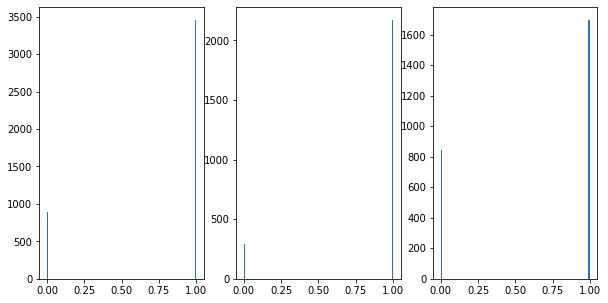

In [17]:
print(100*len(x_val)/(len(x_train)+len(x_val)+len(x_test)))
print(100*len(x_test)/(len(x_train)+len(x_val)+len(x_test)))

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].hist(y_train, bins=100)
ax[1].hist(y_val, bins=100)
ax[2].hist(y_test, bins=100)
plt.show()

## Create dictionary for Dataloader

In [18]:
dict_patches = {'train': x_train,\
              'val': x_val,\
               'test': x_test}
dict_labels = {'train': y_train,\
              'val': y_val,\
               'test': y_test}

## Create Dataloaders

In [24]:
is_resnet = True

In [25]:
if is_resnet == True:
    size_model = (224, 224)
    image_datasets = {x: ImageCustomLoader(dict_patches[x], dict_labels[x], size_image_model, 3, size_model) for x in partitions[0:2]}
else:
    image_datasets = {x: ImageCustomLoader_gray(dict_patches[x], dict_labels[x], size_image_model) for x in partitions[0:2]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchSize,\
                                              shuffle=shuffle_db) for x in partitions[0:2]}
dataset_sizes = {x: len(image_datasets[x]) for x in partitions[0:2]}
print('Data loaded correctly!')
dataset_sizes

Data loaded correctly!


{'train': 4353, 'val': 2465}

## Model

### Create & train model

In [ ]:
class Corrosion_Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        
        
    def forward(self, x):
        
        return y

In [28]:
if is_resnet == True:
    model = resnet18(weights=True)
    num_ftrs = model.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    print(num_ftrs)
    model.fc = nn.Linear(num_ftrs, 1)
    
    nbr_layers_frozen = 10
    for k, parents in enumerate(model.children()):
        for count, child in enumerate(parents.children()):
            for name, param in child.named_parameters():
                if k<nbr_layers_frozen:
                    param.requires_grad=False
                    print("Parents ",k," is frozen now")
                print(child)
else:
  model = Corrosion_Net()

512
Parents  4  is frozen now
BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Parents  4  is frozen now
BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Parents  4  is frozen now
BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2

In [31]:
# torch.set_deterministic(False)
from torchsummary import summary
#summary(model.cuda(), input_size=(3, 224, 224))
#summary(model, input_size=(1, 64, 64))

In [32]:
criterionBCE = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
scheduler = [] # optional: implement scheduler

In [ ]:
# train_process = training_train_only( model, optimizer, criterionBCE, path2Save, 200, partitions[0:2], dataloaders, device, dataset_sizes, 0)
num_channels = 1
if is_resnet == True:
    num_channels = 3
train_process = training_train_val(model, num_channels, optimizer, criterionBCE, path2Save, num_epochs, partitions[0:2], dataloaders, device, dataset_sizes,  initial_epoch, scheduler)
train_process.train()

0


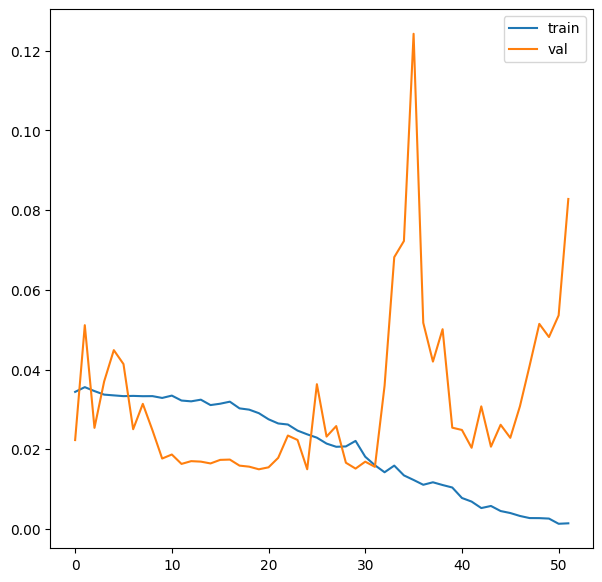

In [ ]:
loss_information = pd.read_csv(results_dir/model_name/'loss_file.csv') 

loss_train = loss_information.train
#loss_train = ndimage.median_filter(loss_train, size=5)

loss_val = loss_information.val
#loss_val = ndimage.median_filter(loss_val, size=5)

fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(loss_train, label="train")
ax.plot(loss_val, label="val")
ax.legend()

## Test

In [ ]:
# options test
#model_name = "Dip_seg_model_loss-BCE_lr-0.001_opt-RMSprop_batchSize-256_nbrEpochs-200_prepo-log_RobustScaler_reproduce_model_JK_v0"
model_pathname = results_dir/ model_name/ 'models/model-50.ckpt'#'/HomeToo/Projects/dip_segmentation/results/Dip_seg_model/models/model-Unet80.ckpt'
print(model_pathname)
tsh = 0.5

/HomeToo/Projects/groove_detection/results/Corrosion_classification_loss-BCE_lr-0.001_opt-RMSprop_batchSize-16_nbrEpochs-200_JK_v0/models/model-Unet50.ckpt


In [ ]:
if is_resnet == True:
    model = resnet18(weights=True)
    num_ftrs = model.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model.fc = nn.Linear(num_ftrs, 1)
else:
    model = Corrosion_Net()
model.load_state_dict(torch.load(model_pathname,  map_location=torch.device('cpu')))
model.to(device)

/HomeSweetHome/JKherroubi/base_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
## metric
from sklearn.metrics import f1_score, precision_recall_fscore_support

In [ ]:
if is_resnet == True:
    size_model = (224, 224)
    image_datasets = {x: ImageCustomLoader(dict_patches[x], dict_labels[x], size_image_model, 3, size_model) for x in [partitions[2]]}
else:
    image_datasets = {x: ImageCustomLoader_gray(dict_patches[x], dict_labels[x], size_image_model) for x in [partitions[2]]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,\
                                              shuffle=False) for x in [partitions[2]]}
dataset_sizes = {x: len(image_datasets[x]) for x in [partitions[2]]}
print('Data loaded correctly!')
dataset_sizes

Data loaded correctly!


{'test': 2543}

In [ ]:
model.eval()
val_dataFrame = {}
val_dataFrame['label'] = []
val_dataFrame['prediction'] = []  
iter = 0
tolerance = 0
for  iteration, batch_data in enumerate(dataloaders['test']):
    patches, labels  = batch_data  
    
    if num_channels == 1:
        patches = patches.unsqueeze(1)
    patches = patches.float()

    patches = patches.to(device)
    labels = labels.to(device)
    
    groove_pred = model(patches)
    groove_pred = groove_pred.to(device)
    
    labels_np = labels.squeeze().cpu().numpy()
    groove_pred_np = (groove_pred.squeeze().detach().cpu().numpy()>tsh)*1#seg_dip.squeeze().detach().cpu().numpy()#
    #seg_dip_np = seg_dip.squeeze().detach().cpu().numpy()
    
#     if (iter % 20) == 0:
#         fig, ax = plt.subplots(1, 1)
#         #ax.imshow(seg_dip_np_previous)
#         ax.imshow(seg_dip.squeeze().detach().cpu().numpy())
    
    patches_2Display = patches.squeeze().cpu().numpy()#np.transpose(patches.squeeze().cpu().numpy(), (1,2,0))
    v_min = np.min(patches_2Display)#[:,:,0]
    v_max = np.max(patches_2Display)#[:,:,0]
#     if labels_np.sum()>0:
#         show_images([ patches_2Display, labels_np, seg_dip_np],\
#                ['img','label','pred'], './' ,v_min, v_max,save=False, display=True)
    val_dataFrame['label'].append(labels_np)
    val_dataFrame['prediction'].append(groove_pred_np)
    
    iter = iter + 1

val_dataFrame['label'] = np.asarray(val_dataFrame['label'])
val_dataFrame['prediction'] = np.asarray(val_dataFrame['prediction'])

In [ ]:
f1 = f1_score(val_dataFrame['label'], val_dataFrame['prediction'])#, average='weighted')    
precision = precision_score(val_dataFrame['label'], val_dataFrame['prediction'])#, average='weighted')
recall = recall_score(val_dataFrame['label'], val_dataFrame['prediction'])#, average='weighted')

print('Precision score = ' + str(precision))
print('Recall score = ' + str(recall))
print('F1 score = ' + str(f1)) 

Precision score = 0.7458085451595458
Recall score = 0.8130896226415094
F1 score = 0.7779971791255289


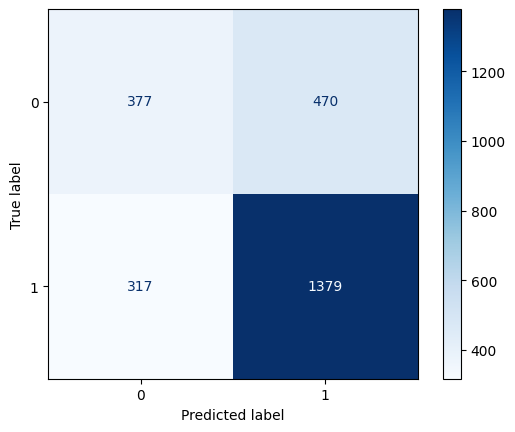

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(val_dataFrame['label'], val_dataFrame['prediction'], cmap='Blues')
plt.show()